# This notebook ...

In [1]:
import sys
import pathlib
import yaml
import subprocess

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

## Load config
The config file specifies the path to data and software repo (due to currently in active development)

In [2]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

## Retrieve Path to Processed Bulk RNA-seq Data and relevant Metadata

In [3]:
ACCESSION = config_dict['data_accession']
BIOMART_EXPORT = config_dict['biomart_export_file']

BULK_DATA_PATH = pathlib.Path(config_dict['data_path']['bulk_data_path']) / ACCESSION
assert BULK_DATA_PATH.exists(), f"Bulk data path not found at {BULK_DATA_PATH}"
BULK_DATA_FILES = BULK_DATA_PATH.glob('*.tsv.gz')
assert BULK_DATA_FILES, f"No bulk data files found in {BULK_DATA_PATH}"
SC_DATA_PATH = pathlib.Path(config_dict['data_path']['sc_data_path'])
METADATA_PATH  = SC_DATA_PATH / f'{ACCESSION}_metadata'
assert METADATA_PATH.exists(), f"Metadata file not found at {METADATA_PATH}"

In [4]:
analysis_config = config_dict['analysis_config']
GENE_ID_COL = analysis_config['source']['bulk']['var']['gene_id_col'] # 'gene_ids'

## Define save path of output

In [5]:
OUTPUT_PATH = REPO_ROOT / 'processed_data'
if not OUTPUT_PATH.exists():
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
assert OUTPUT_PATH.exists(), f"Output path not found at {OUTPUT_PATH}"

## Assebmle raw reads into anndata

Extract counts and metadata

In [6]:
SEP = '\t'
INDEX_COL = 0
SKIP_ROWS = 3
STRAND = 'reverse'
assert STRAND in ['unstranded', 'reverse', 'forward'], f"Invalid strand: {STRAND}"


count_dfs = []
sample_ids = []
dissociation_methods = []
enrichment_methods = []
subject_ids = []
for bulk_data_file in BULK_DATA_FILES:
    
    name_split = bulk_data_file.stem.split('_')
    sample_id = name_split[0]
    sample_ids.append(sample_id)
    dissociation_method = name_split[2]
    dissociation_methods.append(dissociation_method)
    enrichment_method = name_split[3]
    enrichment_methods.append(enrichment_method)
    subject_id = name_split[4]
    subject_ids.append(subject_id)
    
    count_df = pd.read_csv(
        bulk_data_file, 
        sep=SEP, 
        index_col=INDEX_COL,
        skiprows=SKIP_ROWS
    )
    count_df.index.name = 'ensembl_gene_id'
    count_df.columns = ['unstranded', 'forward', 'reverse']
    count_dfs.append(count_df.loc[:, STRAND])

Concatenate counts and metadata

In [7]:
counts_df = pd.concat(count_dfs, axis=1)
counts_df.columns = sample_ids
print(f"Counts DataFrame shape: {counts_df.shape}")
print(counts_df.head())

counts_metadata = pd.DataFrame({
    'gse_id': sample_ids,
    'dissociation_method': dissociation_methods,
    'enrichment_method': enrichment_methods,
    'subject_id': subject_ids
})
counts_metadata = counts_metadata.set_index('gse_id')
print(f"Counts Metadata DataFrame shape: {counts_metadata.shape}")
print(counts_metadata.head())

Counts DataFrame shape: (36601, 24)
                 GSM6720939  GSM6720952  GSM6720936  GSM6720935  GSM6720938  \
ensembl_gene_id                                                               
ENSG00000243485           0           0           0           0           0   
ENSG00000237613           0           0           0           0           0   
ENSG00000186092           0           0           0           0           0   
ENSG00000238009           3           5           5           6           1   
ENSG00000239945           0           0           0           0           0   

                 GSM6720942  GSM6720948  GSM6720943  GSM6720945  GSM6720941  \
ensembl_gene_id                                                               
ENSG00000243485           1           2           2           0           0   
ENSG00000237613           0           0           0           0           0   
ENSG00000186092           0           0           0           0           0   
ENSG00000238009

Construct Anndata

In [8]:
adata = sc.AnnData(counts_df.T)
adata.obs = counts_metadata

## QC and preprocessing

Map Ensembl to Symbol

In [9]:
# 1) Load Biomart export to map Ensembl IDs to Symbols
map_df = pd.read_csv(
    BIOMART_EXPORT, 
    usecols=["Gene stable ID", "Gene name"],
    dtype=str,
    sep='\t',
).set_index("Gene stable ID")["Gene name"]
# 2) Remove duplicates entries as we are using unversioned Ensembl IDs
map_df = map_df[~map_df.index.duplicated(keep="first")]
# 3) Extract the Ensembl IDs from the AnnData object
base_ids = adata.var.index.to_series()
# 4) Map the Ensembl IDs to Symbols using the Biomart export
symbols = base_ids.map(map_df)
# 5) Check for unmapped IDs
n_mapped   = symbols.notna().sum()
print(f"Number of mapped symbols: {n_mapped} / {len(base_ids)}")
# 6) Fill unmapped IDs with the original Ensembl IDs
symbols = symbols.fillna(base_ids)
# 7) keep the original Ensembl IDs
adata.var['ensembl_id'] = adata.var_names
adata.var[GENE_ID_COL] = symbols # make a copy of the symbols
# 8) set the var_names to your mapped symbols
adata.var_names = symbols
adata.var.index.name = 'symbol'
# 9) ensure uniqueness in case of duplicates
adata.var_names_make_unique()
print('Shape of count matrix after mapping: ', adata.X.shape)
adata.var.head()

Number of mapped symbols: 25315 / 36601
Shape of count matrix after mapping:  (24, 36601)


,ensembl_id,gene_ids
symbol,,
MIR1302-2HG,ENSG00000243485,MIR1302-2HG
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
ENSG00000238009,ENSG00000238009,ENSG00000238009
ENSG00000239945,ENSG00000239945,ENSG00000239945


QC

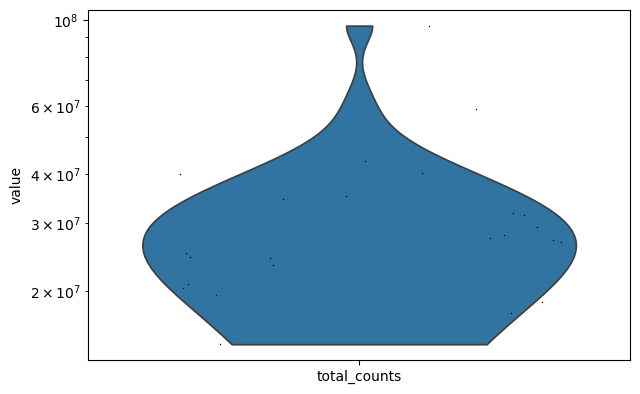

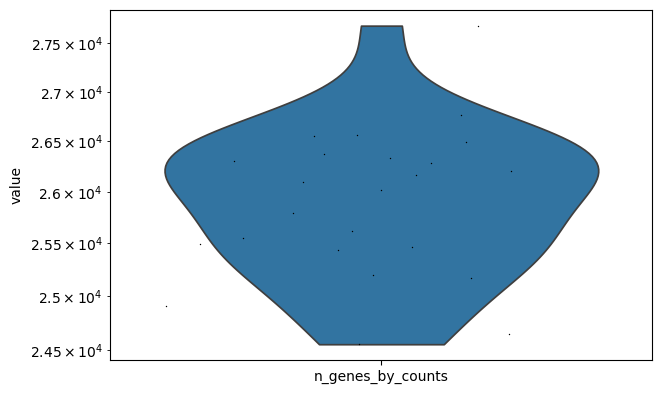

In [10]:
adata.obs["total_counts"] = adata.X.sum(axis=1)
adata.obs["n_genes_by_counts"] = (adata.X > 0).sum(axis=1)
# plot distributions
sc.pl.violin(adata, ["total_counts"], jitter=0.4, log=True)
sc.pl.violin(adata, ["n_genes_by_counts"], jitter=0.4, log=True)

Remove poor qc samples and genes

In [11]:
print(adata.shape)

sc.pp.filter_cells(adata, min_counts=1e6)
sc.pp.filter_cells(adata, min_genes=5000)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.shape)

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

(24, 36601)
(24, 31110)


### Save adata object

In [12]:
adata.write(
    REPO_ROOT / 'processed_data' / f'{ACCESSION}_qc_norm.h5ad'
)